Drake Wagner - dbw2tn

In [2]:
import sqlite3

## Creating the Database Structure

### Tables:
**team**(<u>teamID</u>, name, city)

**player**(<u>name, team, number</u>, position)

**coach**(<u>team</u>, name, nationality)

**stadium**(<u>home_team</u>, name, city, surface_type, capacity)

**match**(<u>date, home_team, away_team</u>, stadium, home_team_score, away_team_score)

In [3]:
conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()

In [4]:
# create team table
cursor.execute('''create table team(
                teamID text,
                name text,
                city text,
                primary key (teamID))''')

In [5]:
# create player table
cursor.execute('''create table player(
                name text,
                team text,
                number int,
                position text,
                primary key (name, team, number),
                foreign key (team) references team(teamID))''')

In [6]:
# create coach table
cursor.execute('''create table coach(
                name text,
                team text,
                nationality text,
                primary key (team),
                foreign key (team) references team(teamID))''')

In [7]:
# create stadium table
cursor.execute('''create table stadium(
                name text,
                city text,
                home_team text,
                surface_type text,
                capacity int,
                primary key (home_team),
                foreign key (home_team) references team(teamID))''')

In [8]:
# create match table
cursor.execute('''create table match(
                home_team text,
                away_team text,
                date date,
                home_team_score int,
                away_team_score int,
                attendance int,
                primary key (date, home_team, away_team),
                foreign key (home_team) references stadium(home_team),
                foreign key (away_team) references team(teamID))''')

In [9]:
# create commits_foul relation table
cursor.execute('''create table commits_foul(
                player text,
                number int,
                team text,
                match_date date,
                home_team text,
                away_team text,
                time int,
                card text,
                primary key (time, match_date, home_team, away_team),
                foreign key (player, number, team) references player(name, number, team),
                foreign key (match_date, home_team, away_team) references match(date, home_team, away_team))''')

In [10]:
# create scores_goal relation table
cursor.execute('''create table scores_goal(
                player text,
                number int,
                team text,
                match_date date,
                home_team text,
                away_team text,
                time int,
                primary key (time, match_date, home_team, away_team),
                foreign key (player, number, team) references player(name, number, team),
                foreign key (match_date, home_team, away_team) references match(date, home_team, away_team))''')

## Input data into database
### Web scraping

In [12]:
# scrape list of teams from MLS website, with links to rosters and team info

import requests
from bs4 import BeautifulSoup
import pandas as pd

clublist_url = "https://www.mlssoccer.com/clubs/"
clublist = requests.get(clublist_url)
clublist_soup = BeautifulSoup(clublist.content, 'html.parser')

In [14]:
# collect data for players in a dataframe

playerdata = pd.DataFrame(columns = ["Name", "Team", "Number", "Position"])
club_names = []
club_ids = []
import json

for element in clublist_soup.find_all('div', {'class': 'mls-o-clubs-hub-clubs-list__club-name'}):
    club_names.append(element.contents[1].contents[0])

for element in clublist_soup.find_all('div', {'class': 'mls-o-clubs-hub-clubs-list__club-links'}):
    roster_url = "https://www.mlssoccer.com" + element.contents[1].attrs['href'] + "roster/"
    roster = requests.get(roster_url)
    roster_soup = BeautifulSoup(roster.content, 'html.parser')
    
    for element in roster_soup.find_all('section', {'class': "mls-l-module mls-l-module--active-roster"}):
        club_info = json.loads(element["data-options"])
        for player in club_info["playersData"]:
            name = player["fullName"]
            team = club_info["clubAbbreviation"]
            number = player["jerseyNumber"]
            position = player["position"]
            playerdata = playerdata.append(pd.DataFrame([[name, team, number, position]], columns = ["Name", "Team", "Number", "Position"]))
            
    club_ids.append(club_info["clubAbbreviation"])
        
playerdata.reset_index(inplace=True)

In [15]:
# use dataframe to populate database

for i in range(len(playerdata)):
    if i == 510: # there is a duplicate value in this row
        continue
    sql = '''insert into player
             (name, team, number, position)
             values
             (:name, :team, :number, :position)'''
    cursor.execute(sql, {'name':playerdata["Name"][i], 'team':playerdata["Team"][i], 'number':playerdata["Number"][i], 'position':playerdata["Position"][i]})
    
    conn.commit()

In [16]:
# manually create list of home cities (not easily accessible on MLS website)

cities = ["Atlanta", "Austin", "Chicago", "Cincinnati", "Denver", "Columbus", "Washington", "Dallas", "Houston", "Kansas City", "Los Angeles", "Los Angeles", "Miami", "Saint Paul", "Montreal", "Nashville", "Boston", "New York", "New York", "Orlando", "Philadelphia", "Portland", "Salt Lake City", "San Jose", "Seattle", "Toronto", "Vancouver"]

In [17]:
# create dataframe of team data using data collected during last step

teamdata = pd.DataFrame()
teamdata["TeamID"] = club_ids
teamdata["Name"] = club_names
teamdata["City"] = cities

In [18]:
# use dataframe to populate database

for i in range(len(teamdata)):
    sql = '''insert into team
             (teamID, name, city)
             values
             (:teamID, :name, :city)'''
    cursor.execute(sql, {'teamID':teamdata["TeamID"][i], 'name':teamdata["Name"][i], 'city':teamdata["City"][i]})
    
    conn.commit()

In [21]:
# scrape list of stadiums from Wikipedia

stadium_url = "https://en.wikipedia.org/wiki/List_of_Major_League_Soccer_stadiums"
stadium = requests.get(stadium_url)
stadium_soup = BeautifulSoup(stadium.content, 'html.parser')

In [31]:
# Collect stadium data in a dataframe

stadiumdata = pd.DataFrame(columns = ["name", "home_team", "city", "surface_type", "capacity"])

tr_list = stadium_soup.find_all('table')[1].find_all('tr')
for i in range(1,len(tr_list)):
    name = tr_list[i].contents[3].contents[0].contents[0]
    home_team = tr_list[i].contents[5].contents[0].string
    city = tr_list[i].contents[7].contents[0].contents[0].split(",")[0]
    surface_type = tr_list[i].contents[15].contents[0].string
    capacity = tr_list[i].contents[11].contents[0]
    
    stadiumdata = stadiumdata.append(pd.DataFrame([[name, home_team, city, surface_type, capacity]], columns = ["name", "home_team", "city", "surface_type", "capacity"]))
    
stadiumdata.reset_index(inplace=True, drop=True)  

In [ ]:
# Create a dictionary to convert full team name to team ID 
# (this teamID is abbreviation used as primary key in post tables)

teamname_abbrev = {}
for i in range(len(teamdata)):
    teamname_abbrev[teamdata["Name"][i]] = teamdata["TeamID"][i]
# some team name styles differ; add manually
teamname_abbrev["Minnesota United FC"] = "MIN"
teamname_abbrev["Los Angeles FC"] = "LAFC"
teamname_abbrev["Orlando City SC"] = "ORL"
teamname_abbrev["Atlanta United FC"] = "ATL"
teamname_abbrev["CF Montréal"] = "MTL"

# Use dataframe and dictionary to populate dataframe

for i in range(len(stadiumdata)):
    sql = '''insert into stadium
             (name, home_team, city, surface_type, capacity)
             values
             (:name, :home_team, :city, :surface_type, :capacity)'''
    cursor.execute(sql, {'name':stadiumdata["name"][i], 'home_team':teamname_abbrev[stadiumdata["home_team"][i]], 'city':stadiumdata["city"][i], 'surface_type':stadiumdata["surface_type"][i], 'capacity':stadiumdata["capacity"][i]})
    
    conn.commit()

In [ ]:
# Scrape coach data from Wikipedia

coaches_url = "https://en.wikipedia.org/wiki/List_of_Major_League_Soccer_coaches"
coaches = requests.get(coaches_url)
coaches_soup = BeautifulSoup(coaches.content, 'html5lib')

In [34]:
# Collect coach data in a dataframe

coachlist = coaches_soup.find_all('table')[0].find_all('tr')

coachdata = pd.DataFrame(columns = ["name", "team", "nationality"])

for i in range(1,len(coachlist)):
    name = coachlist[i].contents[1].string
    nationality = coachlist[i].contents[3].contents[1].string
    team = coachlist[i].contents[7].string
    
    coachdata = coachdata.append(pd.DataFrame([[name, team, nationality]], columns = ["name", "team", "nationality"]))

coachdata.reset_index(inplace=True, drop=True)   

NameError: name 'coaches_soup' is not defined

In [ ]:
# Use dataframe and dictionary to populate database

for i in range(len(coachdata)):
    sql = '''insert into coach
             (name, team, nationality)
             values
             (:name, :team, :nationality)'''
    cursor.execute(sql, {'name':coachdata["name"][i], 'team':teamname_abbrev[coachdata["team"][i]], 'nationality':coachdata["nationality"][i]})
    
    conn.commit()

NameError: name 'coachdata' is not defined

### Manual Entry

We have been unable to find an adequate source from which to scrape data about individual matches, so this data will be input manually using DB Browser.

## Queries

Question ideas:
team records


In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()


sql1 = 'SELECT stadium.capacity, stadium.city, stadium.home_team, stadium.name, \
stadium.surface_type, team.name FROM stadium INNER JOIN team ON stadium.home_team = team.teamID ORDER BY stadium.capacity DESC LIMIT 6'

result = cursor.execute(sql1)
all_stads = result.fetchall()

stad_df = pd.DataFrame(all_stads, columns = ['capacity', 'city', 'home_team', 'stadium_name', 'surface_type', 'team_name'])
print(stad_df)


sql2 = 'SELECT coach.name AS coach_name, coach.team, player.name AS player_name, player.number \
FROM coach \
INNER JOIN player ON player.team = coach.team \
WHERE coach.nationality = "United States"'
result = cursor.execute(sql2)
all_usa_coach = result.fetchall()

usa_coach_df = pd.DataFrame(all_usa_coach)
print(usa_coach_df)

# Only matches of teams starting with A and on february 29th, 2020
sql3 = 'SELECT * \
FROM team, match \
WHERE date LIKE '2020-02-29' AND teamID like 'A%' \
ORDER BY attendance DESC'

result = cursor.execute(sql3)
select_matches = result.fetchall()

sel_mat_df = pd.DataFrame(select_matches)
print(sel_mat_df)

    
# Use the cursor to close the connection to the database, now that we're done.
cursor.close()

NameError: ignored

Text(0.5, 1.0, 'Stadium Capacity by City')

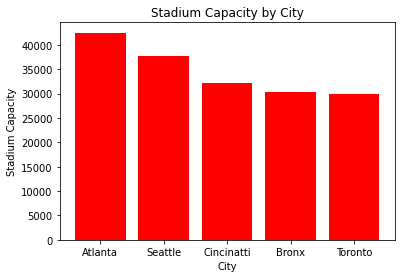

In [ ]:
# matplot
import matplotlib.pyplot as plt
list(stad_df.columns)
pd.DataFrame.head(stad_df)
cities = ['Atlanta', 'Seattle', 'Cincinatti', 'Bronx', 'Toronto']
values = [42500, 37722, 32250, 30321, 30000]
# stad_df = stad_df.iloc[1:]
# stad_df['capacity'] = pd.to_numeric(stad_df['capacity'])
plt.bar(cities, values, color='red')
plt.xlabel('City')
plt.ylabel('Stadium Capacity')
plt.title('Stadium Capacity by City')

In [ ]:
# # Attendance
# SELECT *
# FROM team, match
# WHERE date BETWEEN 2020-02-29 AND 2020-02-30
# ORDER BY attendance DESC

# # American coachs' players
# SELECT coach.name AS coach_name, coach.team, player.name AS player_name, player.number
# FROM coach
# INNER JOIN player ON player.team = coach.team
# WHERE coach.nationality = 'United States'

# # Top 3 largest stadiums
# SELECT stadium.capacity, stadium.city, stadium.home_team, stadium.name, stadium.surface_type, team.name
# FROM stadium
# INNER JOIN team ON stadium.home_team = team.teamID
# ORDER BY stadium.capacity DESC
# LIMIT 3

# # best players' coaches?


# # best home team scores by turf type?





